In [1]:
from experiments import *

/home/dylan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
#model_basic = run_experiment_train_basic()

In [3]:
#run_experiment_inference(model_basic)

Total Trainable Params: 3055360
MoEProbe: Scanning model for routers...
MoEProbe: Attached probes to 2 router layers.


Epoch 1:   0%|                                           | 0/16 [00:00<?, ?it/s]

top experts: [43 42]
top experts: [33 43]


Epoch 1:   6%|▌        | 1/16 [00:00<00:07,  1.91it/s, accuracy=20.3, loss=13.7]

top experts: [43 42]
top experts: [18 43]


Epoch 1:  12%|█▏       | 2/16 [00:00<00:06,  2.13it/s, accuracy=25.2, loss=10.1]

top experts: [43 42]
top experts: [42 43]


Epoch 1:  19%|█▋       | 3/16 [00:01<00:05,  2.17it/s, accuracy=21.1, loss=8.38]

top experts: [42 43]
top experts: [42 43]


Epoch 1:  25%|██▎      | 4/16 [00:01<00:05,  2.18it/s, accuracy=25.8, loss=7.81]

top experts: [42 43]
top experts: [57 43]


Epoch 1:  31%|██▊      | 5/16 [00:02<00:05,  2.19it/s, accuracy=29.5, loss=7.29]

top experts: [42 43]
top experts: [42 43]


Epoch 1:  38%|███▊      | 6/16 [00:02<00:04,  2.15it/s, accuracy=26.1, loss=6.6]

top experts: [42 43]
top experts: [42 43]


Epoch 1:  44%|███▉     | 7/16 [00:03<00:04,  2.19it/s, accuracy=26.4, loss=6.12]

top experts: [42 43]
top experts: [43 42]


Epoch 1:  50%|████▌    | 8/16 [00:03<00:03,  2.20it/s, accuracy=30.3, loss=5.36]

top experts: [42 43]
top experts: [42 43]


Epoch 1:  56%|█████    | 9/16 [00:04<00:03,  2.20it/s, accuracy=23.3, loss=5.48]

top experts: [42 43]
top experts: [42 43]


Epoch 1:  62%|█████▋   | 10/16 [00:04<00:02,  2.19it/s, accuracy=28.7, loss=4.9]

top experts: [42 43]
top experts: [43 42]


Epoch 1:  69%|█████▌  | 11/16 [00:05<00:02,  2.16it/s, accuracy=30.2, loss=4.63]

top experts: [42 43]
top experts: [43 42]


Epoch 1:  75%|██████  | 12/16 [00:05<00:01,  2.13it/s, accuracy=28.4, loss=4.42]

top experts: [42 43]
top experts: [43 42]


Epoch 1:  81%|██████▌ | 13/16 [00:06<00:01,  2.13it/s, accuracy=27.3, loss=4.33]

top experts: [42 43]
top experts: [43 42]


Epoch 1:  88%|███████ | 14/16 [00:06<00:00,  2.13it/s, accuracy=26.2, loss=4.33]

top experts: [42 43]
top experts: [43 42]


Epoch 1:  94%|███████▌| 15/16 [00:06<00:00,  2.14it/s, accuracy=33.1, loss=4.18]

top experts: [42 43]
top experts: [43 42]


 25%|███████████▎                                 | 1/4 [00:00<00:00,  8.07it/s]

top experts: [42 43]
top experts: [42 43]
top experts: [42 43]
top experts: [42 43]


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.84it/s]


top experts: [42 43]
top experts: [43 42]
top experts: [42 43]
top experts: [43 42]
Epoch: 1, Train loss: 6.365, Train acc: 0.269, Val loss: 4.220, Val acc: 0.263 Epoch time = 7.352s


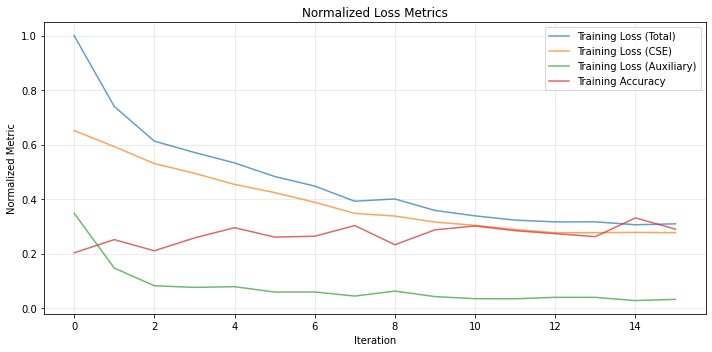

MoEProbe: Captured 40 routing events.


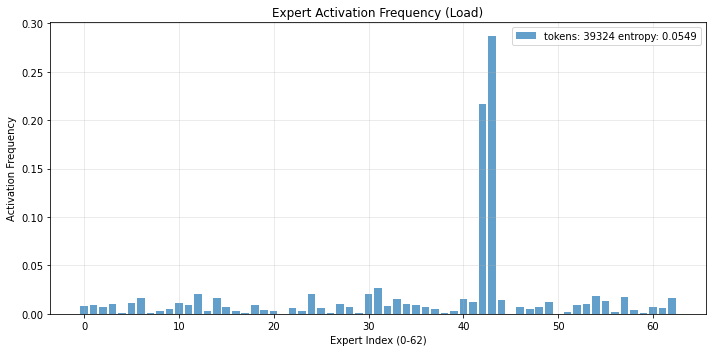

In [4]:
model_moe = run_experiment_train_moe()

MoEProbe: Scanning model for routers...
MoEProbe: Attached probes to 2 router layers.


 25%|███████████▎                                 | 1/4 [00:00<00:00,  8.23it/s]

top experts: [42 43]
top experts: [42 43]
top experts: [42 43]
top experts: [42 43]
top experts: [42 43]
top experts: [42 43]
top experts: [42 43]
top experts: [42 43]


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.00it/s]


top experts: [42 43]
top experts: [42 43]
top experts: [42 43]
top experts: [42 43]
top experts: [42 43]
top experts: [42 43]
top experts: [53 42]
top experts: [53 42]
MoEProbe: Captured 8 routing events.


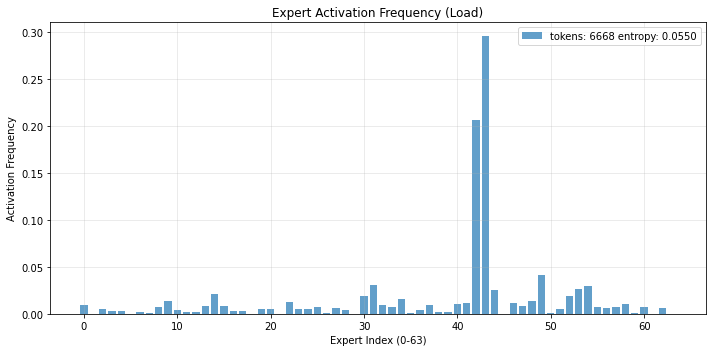

In [5]:
run_experiment_inference_moe_probe(model_moe)